Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Step: 0 loss: 0.761081
Step: 1 loss: 0.755768
Step: 1000 loss: 0.286416
Step: 2000 loss: 0.252377
Step: 3000 loss: 0.270652
Step: 4000 loss: 0.257927
Step: 5000 loss: 0.247479
Step: 6000 loss: 0.241922
Step: 7000 loss: 0.233084
Step: 8000 loss: 0.236649
Step: 9000 loss: 0.224008
Original


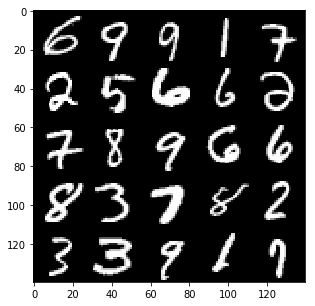

Reconstructed


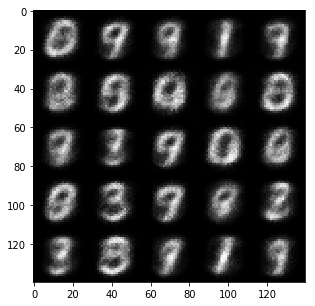

In [13]:
#Autoencoder and his upgrades
import tensorflow as tf
import numpy as np
from tensorflow.examples.tutorials.mnist import input_data
import matplotlib.pyplot as plt
mnist = input_data.read_data_sets("MNIST_data/",one_hot = True)
#hyperparameters
batch_size = 64
latent_space = 256
learning_rate = 0.1
#for new version
rho = 0.05
beta = 1
#regulizer
#one layer autoencoder
ae_weight = {
    "encoder_w": tf.Variable(tf.truncated_normal([784,latent_space],stddev = 0.1)),
    "encoder_b": tf.Variable(tf.truncated_normal([latent_space],stddev = 0.1)),
    "decoder_w": tf.Variable(tf.truncated_normal([latent_space,784],stddev = 0.1)),
    "decoder_b": tf.Variable(tf.truncated_normal([784],stddev = 0.1))
    
}

ae_input = tf.placeholder(tf.float32,[batch_size,784])
noisy_input = tf.placeholder(tf.float32,[batch_size,784])
#for classical autoencoder
#hidden = tf.nn.sigmoid(tf.matmul(ae_input,ae_weight["encoder_w"]) + ae_weight["encoder_b"])
hidden = tf.nn.sigmoid(tf.matmul(noisy_input,ae_weight["encoder_w"]) + ae_weight["encoder_b"])
visible_logit = tf.matmul(hidden,ae_weight["decoder_w"]) + ae_weight["decoder_b"]
visible = tf.nn.sigmoid(visible_logit)
# для разреженного автокодировщика
#data_rho = tf.reduce_mean(hidden,0)
#reg_cost = -tf.reduce_mean(tf.log(data_rho/rho)*rho + tf.log((1-data_rho)/(1-rho))*(1-rho))
#для стандартного автокодировщика
ae_cost = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = visible_logit, labels = ae_input))
#total_cost = ae_cost +beta*reg_cost
optimizer = tf.train.AdagradOptimizer(learning_rate)
#для разреженного автокодировщика
#ae_op = optimizer.minimize(total_cost)

#для стандартного автокодировщика
ae_op = optimizer.minimize(ae_cost)
noisy_prob = 0.4
sess = tf.Session()
sess.run(tf.global_variables_initializer())
for idx in range(10000):
    x_batch,_ =  mnist.train.next_batch(batch_size)
#for noisy encoder
    noisy_mask = np.random.uniform(0,1,[batch_size, 784]) < noisy_prob
    noisy_batch = x_batch.copy()
    noisy_batch[noisy_mask] = 0
    _, l = sess.run([ae_op,ae_cost],feed_dict = {ae_input:x_batch,noisy_input: noisy_batch})
    if idx % 1000 == 0 or idx == 1:
        print("Step: " + str(idx) + " loss: " + str(l))
for_show = 5
canvas_original  = np.empty((28*for_show,28*for_show))
canvas_reconstructed = np.empty((28*for_show,28*for_show))
for idx in range(for_show):
    batch_x, _ = mnist.test.next_batch(64)
    noisy_mask = np.random.uniform(0,1,[batch_size, 784]) < noisy_prob
    noisy_batch = batch_x.copy()
    noisy_batch[noisy_mask] = 0
    g = sess.run(visible,feed_dict = {ae_input:batch_x,noisy_input:batch_x})
    
    for jdx in range(for_show):
        canvas_original[idx*28:(idx + 1)*28,jdx*28:(jdx + 1)*28] = batch_x[jdx].reshape([28,28])
    for jdx in range(for_show):
        canvas_reconstructed[idx*28:(idx + 1)*28,jdx*28:(jdx + 1)*28] = g[jdx].reshape([28,28])
print("Original")

plt.figure(figsize = (for_show,for_show))
plt.imshow(canvas_original,origin = "upper",cmap = "gray")
plt.show()
print("Reconstructed")

plt.figure(figsize = (for_show,for_show))
plt.imshow(canvas_reconstructed,origin = "upper",cmap = "gray")
plt.show()



Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Step: 0 loss: 0.639976
Step: 1 loss: 0.631067
Step: 1000 loss: 0.275555
Step: 2000 loss: 0.234693
Step: 3000 loss: 0.209814
Step: 4000 loss: 0.190938
Step: 5000 loss: 0.17772
Step: 6000 loss: 0.164949
Step: 7000 loss: 0.163109
Step: 8000 loss: 0.147628
Step: 9000 loss: 0.144985
Original


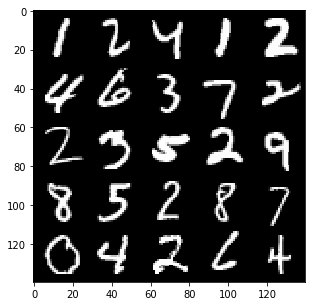

Reconstructed


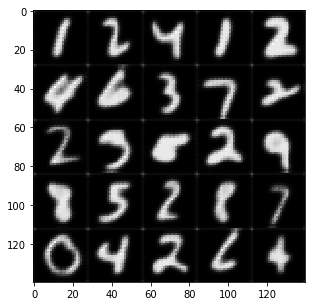

In [8]:
#convolution_encoder
import tensorflow as tf
import numpy as np
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/",one_hot = True)
batch_size,learning_rate = 64,0.01
tf.device("/device:GPU:0")
#remember [m dim of filter,n dim of filter,input channels,output channels]
ae_weight = {
    "conv": tf.Variable(tf.truncated_normal([5,5,1,4],stddev = 0.1)),
    "b_hidden":tf.Variable(tf.truncated_normal([4],stddev = 0.1)),
    "deconv":tf.Variable(tf.truncated_normal([5,5,1,4],stddev = 0.1)),
    "b_visible":tf.Variable(tf.truncated_normal([1],stddev = 0.1))
}
    #для транспонирования
input_shape = tf.stack([batch_size,28,28,1])

ae_input = tf.placeholder(tf.float32,[batch_size,784])
images = tf.reshape(ae_input,[-1,28,28,1])
hidden_logits = tf.nn.conv2d(images,ae_weight["conv"],strides = [1,2,2,1],padding = "SAME") + ae_weight["b_hidden"]
hidden = tf.nn.sigmoid(hidden_logits)
visible_logits = tf.nn.conv2d_transpose(hidden,ae_weight["deconv"],input_shape,strides = [1,2,2,1],padding = "SAME") + ae_weight["b_visible"]
visible = tf.nn.sigmoid(visible_logits)
conv_cost = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = visible_logits,labels = images))
optimizer = tf.train.AdagradOptimizer(learning_rate).minimize(conv_cost)
    
sess = tf.Session()
sess.run(tf.global_variables_initializer())
for idx in range(10000):
    x_batch,_ = mnist.train.next_batch(batch_size)
    _, l = sess.run([optimizer,conv_cost],feed_dict = {ae_input:x_batch})
    if idx % 1000 == 0 or idx == 1:
        print("Step: " + str(idx) + " loss: " + str(l))
for_show = 5
canvas_original  = np.empty((28*for_show,28*for_show))
canvas_reconstructed = np.empty((28*for_show,28*for_show))
for idx in range(for_show):
    batch_x, _ = mnist.test.next_batch(64)
    g = sess.run(visible,feed_dict = {ae_input:batch_x})
    
    for jdx in range(for_show):
        canvas_original[idx*28:(idx + 1)*28,jdx*28:(jdx + 1)*28] = batch_x[jdx].reshape([28,28])
    for jdx in range(for_show):
        canvas_reconstructed[idx*28:(idx + 1)*28,jdx*28:(jdx + 1)*28] = g[jdx].reshape([28,28])
print("Original")

plt.figure(figsize = (for_show,for_show))
plt.imshow(canvas_original,origin = "upper",cmap = "gray")
plt.show()
print("Reconstructed")

plt.figure(figsize = (for_show,for_show))
plt.imshow(canvas_reconstructed,origin = "upper",cmap = "gray")
plt.show()
        


In [ ]:
#multilayer convolution encoder
